<img src='../../media/common/LogoWekeo_Copernicus_RGB_0.png' align='left' height='96px'></img>

<hr>

# Analyzing Wet Snow Extent from SWS Time Series Based on Altitude

## Environment Setup
Before we begin, we need to prepare our environment by installing and importing the necessary Python libraries.

### Load Required Libraries

Most of the following modules are standard Python modules (tested with Python version 3.7.11, <a href="https://github.com/python/cpython/blob/3.7/LICENSE" target="_blank">License</a>):

*Included Python Modules:*  
- os : Miscellaneous operating system interfaces
- glob : Unix style pathname pattern expansion

*Included Python Packages:*
- <a href="https://gdal.org/api/python.html" target="_blank">gdal</a> (version 3.0.2)<br> 
<span style="margin-left:3%;">Tools for programming and manipulating the GDAL (Geospatial Data Abstraction Library). <b>License type:</b> MIT style <a href="https://github.com/OSGeo/gdal/blob/master/LICENSE.TXT" target="_blank">License</a></span><br>
- <a href="https://numpy.org/" target="_blank">numpy</a> (version 1.21.5)<br>
<span style="margin-left:3%;">NumPy is the fundamental package for array computing with Python. <b>License type:</b> BSD <a href="https://www.cgl.ucsf.edu/chimerax/docs/licenses/numpy-LICENSE.txt" target="_blank">License</a></span>
- <a href="https://matplotlib.org/" target="_blank">matplotlib</a> (version 3.5.1)<br>
<span style="margin-left:3%;">Python plotting package. <b>License type:</b> Python Software Foundation <a href="https://www.cgl.ucsf.edu/chimerax/docs/licenses/matplotlib-LICENSE_QT4_EDITOR.txt" target="_blank">License</a></span>

In [24]:
import os
import glob

import gdal
import numpy as np
import matplotlib.pyplot as plt

## Functions

#### Function to Open and Read GeoTIFF Files, Assuming Downloaded Products Have Already Been Extracted

In [25]:
def readTif(file_tif):

    ds = gdal.Open(file_tif)
    
    # Projection
    proj = ds.GetProjection()

    # Dimensions
    width = ds.RasterXSize
    height = ds.RasterYSize

    # Number of bands
    count = ds.RasterCount

    # Metadata for the raster dataset
    meta = ds.GetMetadata()

    data = ds.ReadAsArray()

    ds = None
    
    return data, width, height, count, meta, proj

## Usage

<font color='red'>Enter a valid path and file names into the following box. These are mandatory as input for all following steps:</font>
***

#### <font color='#0080FF'>"path_input"</font>: Enter local path on your machine where products are stored. 
<table><tr><td>
Note: If you copy/paste the path from a windows explorer, add an <b>"r"</b> before the string to interpret backslashes as slashes, as shown in the example below. If your path contains already slashes, remove the <b>"r"</b> in the beginning of the string.
</td></tr></table>

#### <font color='#0080FF'> "files_wsm"</font>: Define the wet snow product file names to be loaded. 
<table><tr><td>
Note: In the template, all files starting with <b>'SWS_'</b> and ending with <b>'_WSM.tif'</b> are searched.
</td></tr></table>

#### <font color='#0080FF'> "file_elev"</font>: Define the digital elevation model file name with the same geometry as the SWS products to be used for the analysis.

<table><tr><td>
Note: In this template, the DEM file name must include <b>"DEM_60m"</b> and extension should be <b>".tif"</b>, and must be stored in the same directory as the SWS products.
</td></tr></table>

In [26]:
path_input =  r"SWS"
files_wsm = glob.glob(os.path.join(path_input, "SWS_*_WSM.tif"))
file_elev = glob.glob(os.path.join(path_input, "*DEM_60m*.tif"))

First, open and read all Wet Snow products for the mountains using the function defined in Box [2].

In [27]:
wsm_datas = []
for file_wsm in files_wsm:
    wsm_datas.append(readTif(file_wsm)[0])

Next, open and read the elevation data using the same function from Box [2].

In [28]:
elev_data = readTif(file_elev[0])[0]

After loading the data, plot the elevation data and its associated colorbar for visualization.

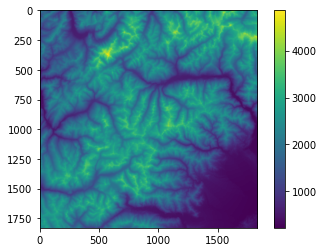

In [29]:
plt.imshow(elev_data);
plt.colorbar();

Then, plot the first SWS product of the time series, ensuring to add a standard colorbar (not the one attached to the product)

For details on the SWS product coding, please refer to the Product User Manual (https://land.copernicus.eu/user-corner/technical-library/hrsi-snow-pum):

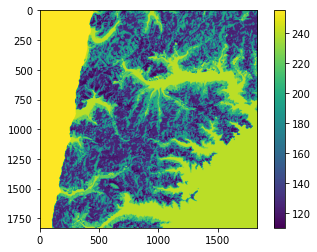

In [30]:
plt.imshow(wsm_datas[0]);
plt.colorbar();

Now, define the elevation intervals to be used for the analysis.
<table><tr><td>
Note: in this example, the elevation range covers 1000 - 4000 m a.s.l., using an altitude interval of 200 m.
</td></tr></table>

In [31]:
dbin = 200
bins = np.arange(1000, 4000+dbin, dbin)
elevs = bins[0:-1]+dbin/2

Extract the elevation information for wet snow pixels and add this data to a database for all SWS products in the time series.

In [32]:
val_wet_snow = 110

hists = []
for wsm_data in wsm_datas:
    sel = (wsm_data == val_wet_snow)

    elev_sel = elev_data[sel]
    
    hists.append(np.histogram(elev_sel, bins=bins)[0])

Retrieve the dates from the SWS product file names to be used as legends in the next step:

In [33]:
labels_wsm = [os.path.splitext(os.path.basename(ele))[0] for ele in files_wsm]

Finally, prepare a plot showing the wet snow extent in relation to the altitude for the full SWS time series used as input.

Ensure that the legend (from the previous step) and axis labels are added for clarity.

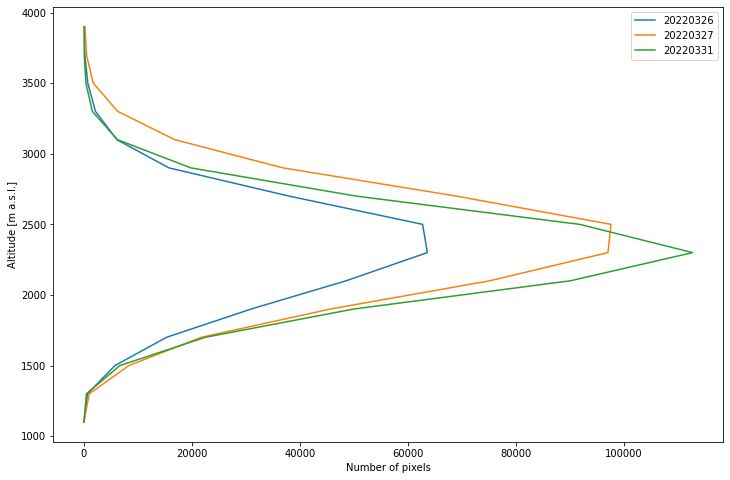

In [34]:
plt.figure(figsize=(12,8));
for hist, label_wsm in zip(hists, labels_wsm):
    plt.plot(hist, elevs, label=label_wsm[4:12]);
    
plt.legend();
plt.xlabel("Number of pixels");
plt.ylabel("Altitude [m a.s.l.]");


***
><span style = "font-family:Verdana; font-size:0.7em">Copyright © <font color='darkblue'>2022</font>, by ENVEO IT GmbH.</span>  
<span style = "font-family:Verdana; font-size:0.7em">Contributors: Lars Keuris,  Gabriele Schwaizer</span>  
<span style = "font-family:Verdana; font-size:0.7em">URL: www.enveo.at</span> 
***
<p style = "font-family:Verdana; font-size:0.7em; line-height:0.5">Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files, to use the Software without restriction.</p>  
<p style = "font-family:Verdana; font-size:0.7em; line-height:1.15; text-align:justify">THE SOFTWARE IS PROVIDED AS IS, WITHOUT WARRANTY OF ANYKIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. <b>IN NO EVENT SHALL THE COPYRIGHT HOLDER BE LIABLE FOR ANY CLAIM, DIRECT INDIRECT, SPECIAL, INCIDENTAL, OR CONSEQUENTIAL DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.</b></p>

*** 